In [ ]:
#IMPORT PACKAGES
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
from torchvision.io import read_image
import torchvision.transforms as T
import random
from sklearn.model_selection import train_test_split
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from PIL import Image

from google.colab import drive
drive.mount('/content/gdrive')

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
#CUSTOM DATASET CLASS FOR FITZPATRICK DATASET
class FitzDataset(Dataset):
  """Fitzpatrick17k Dataset"""

  def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
    """
    Args:
      csv_file (string): Path to the csv file with the metadata/labels for images.
      img_dir (string): Directory with all the images.
      transform (callable, optional): Optional transform to be applied
          on the image of a sample.
      target_transform (callable, optional): Optional transform to be
          applied on the features of the sample.
    """
    self.img_labels = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, index):
    #if torch.is_tensor(index):
    #  index = index.tolist()

    #get image
    img_name = os.path.join(self.img_dir, (self.img_labels['md5hash'][index] + '.jpg'))
    image = read_image(img_name)
    image = image.float()
    #normalization?
    mean, std = Tensor.mean(image), Tensor.std(image)
    normalize_transform = T.Normalize(mean, std)
    image = normalize_transform(image)

    #get metadata
    # label: 0 or 1, noncancerous or cancerous
    label = self.img_labels['binary_cond'][index]

    # fitzpatrick scale: 1-6
    fitzscale = self.img_labels['fitzpatrick'][index]


    #if transforms are to be performed on the sample, this will trigger them
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    if self.target_transform:
      fitzscale = self.target_transform(fitzscale)

    return image, label, fitzscale

  def get_indices_based_on_feature(self, scale):
        # Assuming the feature is a column in self.img_labels
        return self.img_labels[self.img_labels['fitzpatrick'] == scale].index.tolist()


#Data Analysis

In [ ]:
# load data
df = pd.read_csv("/content/gdrive/MyDrive/Team_1/Data/Fitzpatrick17/fitzpatrick17k.csv")
df.drop(df.index[df['fitzpatrick'] == -1].tolist(), axis = 'index', inplace = True)

In [ ]:
df

,Unnamed: 0,md5hash,fitzpatrick,label,nine_partition_label,three_partition_label,qc,url,url_alphanum
0,0,5e82a45bc5d78bd24ae9202d194423f8,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...
1,1,fa2911a9b13b6f8af79cb700937cc14f,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...
2,2,d2bac3c9e4499032ca8e9b07c7d3bc40,2,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...
3,3,0a94359e7eaacd7178e06b2823777789,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...
4,4,a39ec3b1f22c08a421fa20535e037bba,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...
...,...,...,...,...,...,...,...,...,...
16571,16548,add52850b24199d9c49f2882f67c2b37,3,lichen amyloidosis,inflammatory,non-neoplastic,NaN,http://atlasdermatologico.com.br/img?imageId=3694,httpwwwatlasdermatologicocombrimgimageId3694.jpg
16572,16554,cd90e491ddaa92f0f4eb07f73aa09f64,5,scleroderma,inflammatory,non-neoplastic,NaN,http://atlasdermatologico.com.br/img?imageId=4529,httpwwwatlasdermatologicocombrimgimageId4529.jpg
16573,16559,5f1ed6de6a9110d7dc580a6a0312af63,4,pityriasis rosea,inflammatory,non-neoplastic,NaN,http://atlasdermatologico.com.br/img?imageId=5630,httpwwwatlasdermatologicocombrimgimageId5630.jpg
16574,16568,f198aaf1f0550c2464b285454d34926e,3,myiasis,inflammatory,non-neoplastic,NaN,http://atlasdermatologico.com.br/img?imageId=4609,httpwwwatlasdermatologicocombrimgimageId4609.jpg


In [ ]:
def extract_images(fitzpatrick):
  img_dir = "/content/gdrive/MyDrive/Team_1/Data/Fitzpatrick17/fitz17k_img/"
  temp = df[(df.fitzpatrick==fitzpatrick)]
  path_ = os.path.join(img_dir, (temp.md5hash.sample(1).iloc[0] + '.jpg'))
  img = read_image(path_)

  plt.imshow(img.permute(1,2,0))
  plt.axis('off')
  plt.title(f'Fitzpatrick Type {fitzpatrick}')
  plt.show()

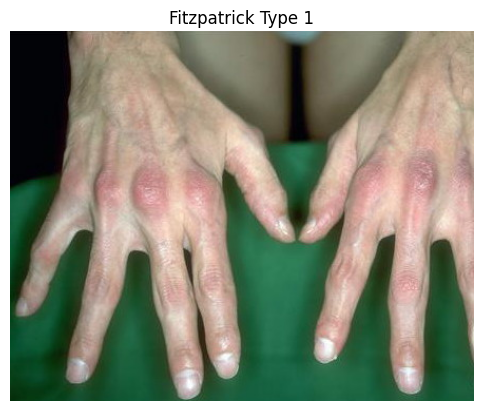

In [ ]:
extract_images(1)

Text(0.5, 1.0, 'Histogram of Cancer Types')

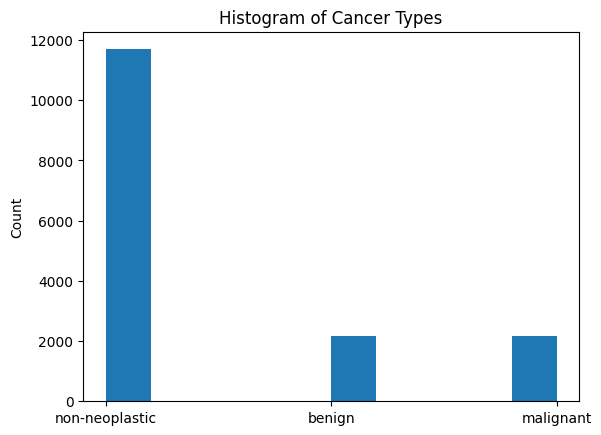

In [ ]:
plt.hist(df["three_partition_label"], align='mid')
plt.ylabel('Count')
plt.title('Histogram of Cancer Types')

In [ ]:
pivot_df = df.groupby(['fitzpatrick', 'three_partition_label']).size().unstack(fill_value=0)
df_percentage = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
df_percentage['fitzpatrick'] = ['Type I', 'Type II', 'Type III', 'Type IV', 'Type V', 'Type VI']

In [ ]:
df_percentage

three_partition_label,benign,malignant,non-neoplastic,fitzpatrick
fitzpatrick,,,,
1,15.066169,15.371564,69.562267,Type I
2,13.955907,15.432612,70.611481,Type II
3,14.359129,13.784764,71.856106,Type III
4,13.196692,10.823445,75.979863,Type IV
5,10.371820,9.589041,80.039139,Type V
6,6.929134,9.606299,83.464567,Type VI


Text(0, 0.5, 'Percentage')

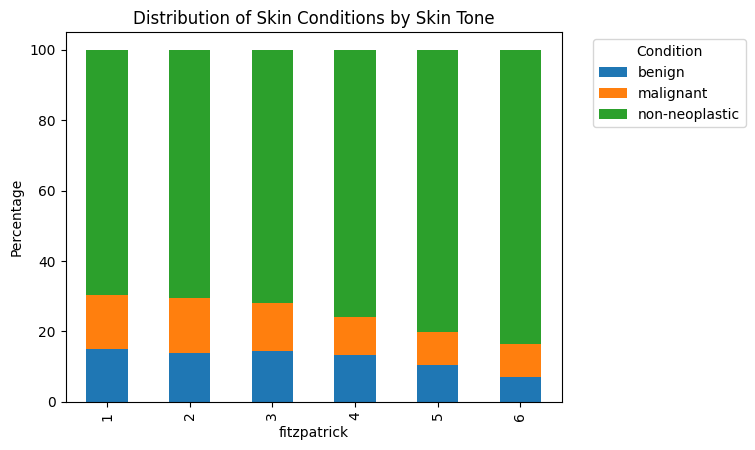

In [ ]:
df_percentage.plot(kind='bar', stacked=True)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Distribution of Skin Conditions by Skin Tone")
plt.ylabel('Percentage')

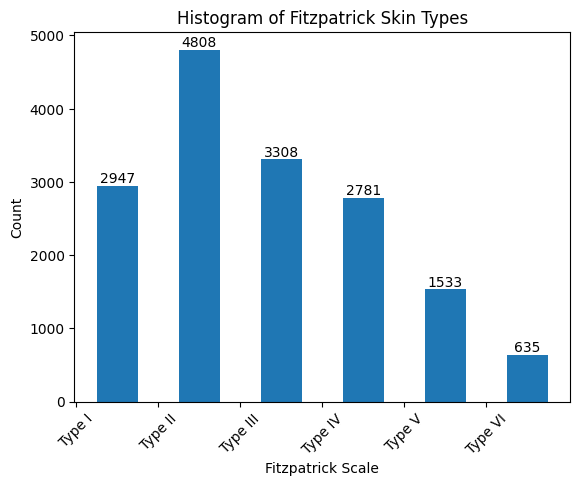

In [ ]:
# Assuming 'data' is a list or array-like object with your histogram data
data = [len(df[df.fitzpatrick==1]),len(df[df.fitzpatrick==2]),len(df[df.fitzpatrick==3]),
        len(df[df.fitzpatrick==4]),len(df[df.fitzpatrick==5]),len(df[df.fitzpatrick==6])] # Example data
labels = ['Type I', 'Type II', 'Type III', 'Type IV', 'Type V', 'Type VI']

# Create the histogram
counts, bins, patches = plt.hist(range(1, len(data)+1), bins=range(1, len(labels) + 2), weights=data, rwidth=0.5)

# Add count labels on top of each histogram bar
for rect, label in zip(patches, data):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height, label, ha='center', va='bottom')

# Set the x-axis ticks to be at the center of each bin, and use the custom string labels
plt.xticks(ticks=range(1, len(labels) + 1), labels=labels, rotation=45)

# Adding labels and title
plt.ylabel('Count')
plt.xlabel('Fitzpatrick Scale')
plt.title('Histogram of Fitzpatrick Skin Types')

# Show the plot
plt.show()

# Data Preprocessing

In [ ]:
# preprocess the data
# only keep the useful columns
# combine benign and malignant cancers together
img_labels = pd.read_csv("/content/gdrive/MyDrive/Team_1/Data/Fitzpatrick17/fitzpatrick17k.csv")
img_labels = img_labels[['md5hash','fitzpatrick', 'three_partition_label']]
img_labels['three_cond'] = pd.factorize(img_labels['three_partition_label'])[0]
img_labels = img_labels.drop(columns=['three_partition_label'])
img_labels.drop(img_labels.index[img_labels['fitzpatrick'] == -1].tolist(), axis = 'index', inplace = True)
binary = [0 if i == 0 else 1 for i in img_labels.three_cond]
img_labels['binary_cond'] = binary

In [ ]:
# train-test split 80:20 ratio
img_train, img_test = train_test_split(img_labels, test_size=0.2)

In [ ]:
# saving in drive
img_train.to_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train.csv")
img_test.to_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_test.csv")

In [ ]:
img_train = pd.read_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train.csv")

In [ ]:
img_train[(img_train.fitzpatrick == 1) & (img_train.binary_cond == 1)]

,Unnamed: 0,md5hash,fitzpatrick,three_cond,binary_cond
4,2610,4dc08af974e49708c2a572d40c44e1c6,1,2,1
9,8193,64701a744eb73be65ed2da19db4092dd,1,1,1
36,9139,db863680fb8d9b3754a55fe246163c2d,1,1,1
70,3978,b49e517f6e88f5f0f139927acd7e00a3,1,1,1
92,6395,c8adb004ca533f6be5fb1a83acc7515e,1,2,1
...,...,...,...,...,...
12668,11950,44ab470249555e7936c6bf6f196f0292,1,2,1
12670,9068,022713978927e0e94227c248cb1592c7,1,2,1
12673,9386,0a89bf3ba5412346ea9a0f0c7e70818d,1,1,1
12737,12064,b3c86bb9fac904880ece450b882ee8d6,1,2,1


In [ ]:
test = pd.read_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_test.csv").drop(columns=['Unnamed: 0'])

In [ ]:
test

,md5hash,fitzpatrick,three_cond,binary_cond
0,3a96f717f1fcda0c1ec2c7bc48ce355c,4,0,0
1,51818eb051cbb1fc25e967a12e1f44cf,5,0,0
2,a0813aad14b96d669342ef81e4d6bab0,4,0,0
3,a3adb40d77e92e75fd62f55fb17a89f8,4,0,0
4,a9b343996d7803385c0c4554a622a6af,4,0,0
...,...,...,...,...
3198,b205162338ed0a6a8915a34d04ad7081,6,0,0
3199,49086eca0384325dfe2439bd3df3d3fa,2,0,0
3200,a4280c9e0cd2206daf06d3ab32bc4a51,5,0,0
3201,768817a0507dcc036f79321e6f8ad1da,2,0,0


# Models

### Test data

This test set is used for all models

In [ ]:
# load test data
fitz_test = FitzDataset(csv_file = "/content/gdrive/MyDrive/CSC2529/fitz17k_test.csv",
                          img_dir = "/content/gdrive/MyDrive/Team_1/Data/Fitzpatrick17/fitz17k_img/",
                          transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

In [ ]:
test_dl = DataLoader(fitz_test)

### Baseline: Model 1 with entire data

In [ ]:
# load training data
fitz_dataset = FitzDataset(csv_file = "/content/gdrive/MyDrive/CSC2529/fitz17k_train.csv",
                           img_dir = "/content/gdrive/MyDrive/fitz17k_img/",

                          transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

In [ ]:
len(fitz_dataset)

12809

In [ ]:
train_dl = DataLoader(fitz_dataset, batch_size=32, shuffle=True)

In [ ]:
# load pre-trained model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(2):
  model.train()
  for input, label, fitzs in train_dl:
    optimizer.zero_grad()
    outputs = model(input)
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()
print(f'Loss: {loss.item()}')

Loss: 0.23920243978500366


In [ ]:
acc_1 = []
acc_2 = []
acc_3 = []
acc_4 = []
acc_5 = []
acc_6 = []

In [ ]:
model.eval()
with torch.no_grad():
    for inputs, labels, fitz in test_dl:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct = 0
        if predicted == labels: correct = 1
        match fitz:
          case 1: acc_1.append(correct)
          case 2: acc_2.append(correct)
          case 3: acc_3.append(correct)
          case 4: acc_4.append(correct)
          case 5: acc_5.append(correct)
          case 6: acc_6.append(correct)

In [ ]:
print(f"For Fitzpatrick I, the accuracy is {sum(acc_1)/len(acc_1)}")
print(f"For Fitzpatrick II, the accuracy is {sum(acc_2)/len(acc_2)}")
print(f"For Fitzpatrick III, the accuracy is {sum(acc_3)/len(acc_3)}")
print(f"For Fitzpatrick IV, the accuracy is {sum(acc_4)/len(acc_4)}")
print(f"For Fitzpatrick V, the accuracy is {sum(acc_5)/len(acc_5)}")
print(f"For Fitzpatrick VI, the accuracy is {sum(acc_6)/len(acc_6)}")

For Fitzpatrick I, the accuracy is 0.7065573770491803
For Fitzpatrick II, the accuracy is 0.7141393442622951
For Fitzpatrick III, the accuracy is 0.722397476340694
For Fitzpatrick IV, the accuracy is 0.7629233511586453
For Fitzpatrick V, the accuracy is 0.8052805280528053
For Fitzpatrick VI, the accuracy is 0.8067226890756303


### Model 2 Balance in Fitzpatrick

In [ ]:
# load training data
fitz_dataset = FitzDataset(csv_file = "/content/gdrive/MyDrive/CSC2529/fitz17k_train.csv",
                           img_dir = "/content/gdrive/MyDrive/fitz17k_img/",

                          transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

In [ ]:
#indices for each skin condition
img_labels = pd.read_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train.csv")
skin_1 = img_labels.index[img_labels['fitzpatrick'] == 1].tolist()
skin_2 = img_labels.index[img_labels['fitzpatrick'] == 2].tolist()
skin_3 = img_labels.index[img_labels['fitzpatrick'] == 3].tolist()
skin_4 = img_labels.index[img_labels['fitzpatrick'] == 4].tolist()
skin_5 = img_labels.index[img_labels['fitzpatrick'] == 5].tolist()
skin_6 = img_labels.index[img_labels['fitzpatrick'] == 6].tolist()

In [ ]:
# undersampling to achieve balance in fitzpatrick scale subgroups
bal_skin_1 = random.sample(skin_1, k=len(skin_6))
bal_skin_2 = random.sample(skin_2, k=len(skin_6))
bal_skin_3 = random.sample(skin_3, k=len(skin_6))
bal_skin_4 = random.sample(skin_4, k=len(skin_6))
bal_skin_5 = random.sample(skin_5, k=len(skin_6))
bal_skin_6 = skin_6

#grab the subsets of the main dataset
train_skin1, test_skin1 = torch.utils.data.random_split(torch.utils.data.Subset(fitz_dataset, bal_skin_1), [len(skin_6), 0])
train_skin2, test_skin2 = torch.utils.data.random_split(torch.utils.data.Subset(fitz_dataset, bal_skin_2), [len(skin_6), 0])
train_skin3, test_skin3 = torch.utils.data.random_split(torch.utils.data.Subset(fitz_dataset, bal_skin_3), [len(skin_6), 0])
train_skin4, test_skin4 = torch.utils.data.random_split(torch.utils.data.Subset(fitz_dataset, bal_skin_4), [len(skin_6), 0])
train_skin5, test_skin5 = torch.utils.data.random_split(torch.utils.data.Subset(fitz_dataset, bal_skin_5), [len(skin_6), 0])
train_skin6, test_skin6 = torch.utils.data.random_split(torch.utils.data.Subset(fitz_dataset, bal_skin_6), [len(skin_6), 0])

bal_train_data = torch.utils.data.ConcatDataset([train_skin1, train_skin2, train_skin3, train_skin4, train_skin5, train_skin6])
train_dl = DataLoader(bal_train_data)


In [ ]:
len(bal_train_data)

3096

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(5):
  model.train()
  for input, label, fitzs in train_dl:
    optimizer.zero_grad()
    outputs = model(input)
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()

print(f'Loss: {loss.item()}')

Loss: 0.2254706621170044


In [ ]:
acc_1 = []
acc_2 = []
acc_3 = []
acc_4 = []
acc_5 = []
acc_6 = []

In [ ]:
model.eval()
with torch.no_grad():
    for inputs, labels, fitz in test_dl:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct = 0
        if predicted == labels: correct = 1
        match fitz:
          case 1: acc_1.append(correct)
          case 2: acc_2.append(correct)
          case 3: acc_3.append(correct)
          case 4: acc_4.append(correct)
          case 5: acc_5.append(correct)
          case 6: acc_6.append(correct)

In [ ]:
print(f"For Fitzpatrick I, the accuracy is {sum(acc_1)/len(acc_1)}")
print(f"For Fitzpatrick II, the accuracy is {sum(acc_2)/len(acc_2)}")
print(f"For Fitzpatrick III, the accuracy is {sum(acc_3)/len(acc_3)}")
print(f"For Fitzpatrick IV, the accuracy is {sum(acc_4)/len(acc_4)}")
print(f"For Fitzpatrick V, the accuracy is {sum(acc_5)/len(acc_5)}")
print(f"For Fitzpatrick VI, the accuracy is {sum(acc_6)/len(acc_6)}")

For Fitzpatrick I, the accuracy is 0.6819672131147541
For Fitzpatrick II, the accuracy is 0.6885245901639344
For Fitzpatrick III, the accuracy is 0.7066246056782335
For Fitzpatrick IV, the accuracy is 0.7593582887700535
For Fitzpatrick V, the accuracy is 0.801980198019802
For Fitzpatrick VI, the accuracy is 0.8151260504201681


### Model 3 Balance in label

In [ ]:
# compute how many cancerous cases in the data
disease_count = sum(img_train.binary_cond == 1)

In [ ]:
# sample as much as the cancerous cases to achieve balance in label
r_non_disease = img_train[img_train.binary_cond == 0].sample(disease_count)

In [ ]:
bal_disease_train = pd.concat([r_non_disease, img_train[img_train.binary_cond == 1]]).sample(frac=1).reset_index(drop=True)

In [ ]:
bal_disease_train.to_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_bal_disease_train.csv")

In [ ]:
bal_disease_train_ = FitzDataset(csv_file = "/content/gdrive/MyDrive/CSC2529/fitz17k_bal_disease_train.csv",
                          img_dir = "/content/gdrive/MyDrive/Team_1/Data/Fitzpatrick17/fitz17k_img/",
                          transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

In [ ]:
len(pd.read_csv(("/content/gdrive/MyDrive/CSC2529/fitz17k_bal_disease_train.csv")))

6838

In [ ]:
bal_disease_train_dl = DataLoader(bal_disease_train_, batch_size=32, shuffle=True)

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(5):
  model.train()
  for input, label, fitzs in bal_disease_train_dl:
    optimizer.zero_grad()
    outputs = model(input)
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()

print(f'Loss: {loss.item()}')

Loss: 0.6781200170516968


In [ ]:
acc_1 = []
acc_2 = []
acc_3 = []
acc_4 = []
acc_5 = []
acc_6 = []

In [ ]:
model.eval()
with torch.no_grad():
    for inputs, labels, fitz in test_dl:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct = 0
        if predicted == labels: correct = 1
        match fitz:
          case 1: acc_1.append(correct)
          case 2: acc_2.append(correct)
          case 3: acc_3.append(correct)
          case 4: acc_4.append(correct)
          case 5: acc_5.append(correct)
          case 6: acc_6.append(correct)

In [ ]:
print(f"For Fitzpatrick I, the accuracy is {sum(acc_1)/len(acc_1)}")
print(f"For Fitzpatrick II, the accuracy is {sum(acc_2)/len(acc_2)}")
print(f"For Fitzpatrick III, the accuracy is {sum(acc_3)/len(acc_3)}")
print(f"For Fitzpatrick IV, the accuracy is {sum(acc_4)/len(acc_4)}")
print(f"For Fitzpatrick V, the accuracy is {sum(acc_5)/len(acc_5)}")
print(f"For Fitzpatrick VI, the accuracy is {sum(acc_6)/len(acc_6)}")

For Fitzpatrick I, the accuracy is 0.7459016393442623
For Fitzpatrick II, the accuracy is 0.735655737704918
For Fitzpatrick III, the accuracy is 0.7476340694006309
For Fitzpatrick IV, the accuracy is 0.7825311942959001
For Fitzpatrick V, the accuracy is 0.8118811881188119
For Fitzpatrick VI, the accuracy is 0.8319327731092437


### Model 4 Balance in both label and Fitzpatrick

In [ ]:
# find data size of each fitzpatrick subgroup in the balance-in-label dataset
skin_1_ = bal_disease_train_.get_indices_based_on_feature(1)
skin_2_ = bal_disease_train_.get_indices_based_on_feature(2)
skin_3_ = bal_disease_train_.get_indices_based_on_feature(3)
skin_4_ = bal_disease_train_.get_indices_based_on_feature(4)
skin_5_ = bal_disease_train_.get_indices_based_on_feature(5)
skin_6_ = bal_disease_train_.get_indices_based_on_feature(6)

In [ ]:
bal_skin_1_ = random.sample(skin_1_, k=len(skin_6_))
bal_skin_2_ = random.sample(skin_2_, k=len(skin_6_))
bal_skin_3_ = random.sample(skin_3_, k=len(skin_6_))
bal_skin_4_ = random.sample(skin_4_, k=len(skin_6_))
bal_skin_5_ = random.sample(skin_5_, k=len(skin_6_))
bal_skin_6_ = skin_6_

In [ ]:
# undersampling to achieve balance in fitzpatrick subgroups
train_skin1, test_skin1 = torch.utils.data.random_split(torch.utils.data.Subset(fitz_dataset, bal_skin_1_), [len(skin_6_), 0])
train_skin2, test_skin2 = torch.utils.data.random_split(torch.utils.data.Subset(fitz_dataset, bal_skin_2_), [len(skin_6_), 0])
train_skin3, test_skin3 = torch.utils.data.random_split(torch.utils.data.Subset(fitz_dataset, bal_skin_3_), [len(skin_6_), 0])
train_skin4, test_skin4 = torch.utils.data.random_split(torch.utils.data.Subset(fitz_dataset, bal_skin_4_), [len(skin_6_), 0])
train_skin5, test_skin5 = torch.utils.data.random_split(torch.utils.data.Subset(fitz_dataset, bal_skin_5_), [len(skin_6_), 0])
train_skin6, test_skin6 = torch.utils.data.random_split(torch.utils.data.Subset(fitz_dataset, bal_skin_6_), [len(skin_6_), 0])

#glue the sub-datasets into train and test datasets
bal_inboth_train_data = torch.utils.data.ConcatDataset([train_skin1, train_skin2, train_skin3, train_skin4, train_skin5, train_skin6])

In [ ]:
len(bal_inboth_train_data)

1440

In [ ]:
bal_inboth_train_data_dl = DataLoader(bal_inboth_train_data, batch_size=32, shuffle=True)

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(5):
  model.train()
  for input, label, fitzs in bal_inboth_train_data_dl:
    optimizer.zero_grad()
    outputs = model(input)
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()
print(f'Loss: {loss.item()}')

Loss: 0.5402420163154602


In [ ]:
acc_1 = []
acc_2 = []
acc_3 = []
acc_4 = []
acc_5 = []
acc_6 = []

In [ ]:
model.eval()
with torch.no_grad():
    for inputs, labels, fitz in test_dl:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct = 0
        if predicted == labels: correct = 1
        match fitz:
          case 1: acc_1.append(correct)
          case 2: acc_2.append(correct)
          case 3: acc_3.append(correct)
          case 4: acc_4.append(correct)
          case 5: acc_5.append(correct)
          case 6: acc_6.append(correct)

In [ ]:
print(f"For Fitzpatrick I, the accuracy is {sum(acc_1)/len(acc_1)}")
print(f"For Fitzpatrick II, the accuracy is {sum(acc_2)/len(acc_2)}")
print(f"For Fitzpatrick III, the accuracy is {sum(acc_3)/len(acc_3)}")
print(f"For Fitzpatrick IV, the accuracy is {sum(acc_4)/len(acc_4)}")
print(f"For Fitzpatrick V, the accuracy is {sum(acc_5)/len(acc_5)}")
print(f"For Fitzpatrick VI, the accuracy is {sum(acc_6)/len(acc_6)}")

For Fitzpatrick I, the accuracy is 0.7081967213114754
For Fitzpatrick II, the accuracy is 0.6987704918032787
For Fitzpatrick III, the accuracy is 0.722397476340694
For Fitzpatrick IV, the accuracy is 0.7415329768270945
For Fitzpatrick V, the accuracy is 0.7788778877887789
For Fitzpatrick VI, the accuracy is 0.7983193277310925


### Model 5 Simple Augmentation

#### Subgroups

In [ ]:
# partition the data into 12 subgroups
f1_b0 = img_train[(img_train.fitzpatrick == 1) & (img_train.binary_cond == 0)]
f1_b1 = img_train[(img_train.fitzpatrick == 1) & (img_train.binary_cond == 1)]

f2_b0 = img_train[(img_train.fitzpatrick == 2) & (img_train.binary_cond == 0)]
f2_b1 = img_train[(img_train.fitzpatrick == 2) & (img_train.binary_cond == 1)]

f3_b0 = img_train[(img_train.fitzpatrick == 3) & (img_train.binary_cond == 0)]
f3_b1 = img_train[(img_train.fitzpatrick == 3) & (img_train.binary_cond == 1)]

f4_b0 = img_train[(img_train.fitzpatrick == 4) & (img_train.binary_cond == 0)]
f4_b1 = img_train[(img_train.fitzpatrick == 4) & (img_train.binary_cond == 1)]

f5_b0 = img_train[(img_train.fitzpatrick == 5) & (img_train.binary_cond == 0)]
f5_b1 = img_train[(img_train.fitzpatrick == 5) & (img_train.binary_cond == 1)]

f6_b0 = img_train[(img_train.fitzpatrick == 6) & (img_train.binary_cond == 0)]
f6_b1 = img_train[(img_train.fitzpatrick == 6) & (img_train.binary_cond == 1)]

In [ ]:
# saving them
f1_b0.to_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f1_b0.csv")
f1_b1.to_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f1_b1.csv")

f2_b0.to_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f2_b0.csv")
f2_b1.to_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f2_b1.csv")

f3_b0.to_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f3_b0.csv")
f3_b1.to_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f3_b1.csv")

f4_b0.to_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f4_b0.csv")
f4_b1.to_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f4_b1.csv")

f5_b0.to_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f5_b0.csv")
f5_b1.to_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f5_b1.csv")

f6_b0.to_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f6_b0.csv")
f6_b1.to_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f6_b1.csv")

#### Simple Augmentation on subgroups

In [ ]:
img_dir = "/content/gdrive/MyDrive/Team_1/Data/Fitzpatrick17/fitz17k_img/"

In [ ]:
# augmentation techniques that will be applied to each image
transform_image = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.RandomVerticalFlip(p=0.7),
     transforms.RandomApply([transforms.RandomRotation(45)], p=0.7)
    ])

Augmenting the subgroup with fitzpatrick scale 5 and with disease: Since we need around 600 data points and the original set contains 246 data points, we need to augment each image twice.

In [ ]:
img_f5_b1 = pd.read_csv("/content/drive/MyDrive/CSC2529/fitz17k_train_f5_b1.csv")
img_f5_b1

,Unnamed: 0.1,Unnamed: 0,md5hash,fitzpatrick,three_cond,binary_cond
0,10,14637,1035f09922e702b21f1650279ff4a0ab,5,1,1
1,24,2686,7689c9b4a38392e45c688cad15252e8e,5,2,1
2,27,411,b53a5cc389f78ded1e73df82aeae505c,5,1,1
3,87,15980,1d56b7d688b6b276893107a6bdb93bba,5,2,1
4,154,3596,7995475c6fa1b38a709c12c249751ff6,5,1,1
...,...,...,...,...,...,...
241,12627,14050,a4df5fa2bab38ee98922e0fbc586b93f,5,2,1
242,12637,5311,be8b6845068f1070f3052fb2e54cc48a,5,1,1
243,12653,14446,1d8fcc49e4dda6868fcf76916fc14405,5,2,1
244,12683,3397,e0fedce02782d3e39feb80fd57380226,5,2,1


In [ ]:
images_tobe_aug = [read_image(os.path.join(img_dir, image_path + '.jpg')) for image_path in img_f5_b1["md5hash"]]
aug_rename = []
for i in range(2):
  aug_rename+=[image_path + "_aug_" + str(i) for image_path in img_f5_b1["md5hash"]]
augmented_f5_b1 = []
for i in range(2):
  augmented_f5_b1+=[transform_image(image) for image in images_tobe_aug]
[Image.fromarray(img.permute(1, 2, 0).numpy()).save("/content/drive/MyDrive/CSC2529/simple_aug_img/" + aug_rename[idx] + ".jpg")for idx, img in enumerate(augmented_f5_b1)]

Augmenting the subgroup with fitzpatrick scale 6 and with disease: Since we need around 600 data points and the original set contains 83 data points, we need to augment each image 7 times.

In [ ]:
img_f6_b1 = pd.read_csv("/content/drive/MyDrive/CSC2529/fitz17k_train_f6_b1.csv")
img_f6_b1

,Unnamed: 0.1,Unnamed: 0,md5hash,fitzpatrick,three_cond,binary_cond
0,219,13769,3a2548935342032a9aff94b776e31c1d,6,2,1
1,300,8150,af048401c6e99acaba177eef6c43c45c,6,2,1
2,568,4909,6e8e9409b9996913fdaffe8676b0275a,6,1,1
3,580,1125,30a0b728b7c6da516439bae2e0b0cf20,6,1,1
4,649,1633,13aeee2d0e9c61d9d86714c96f9dbd0c,6,1,1
...,...,...,...,...,...,...
78,12228,5554,e252f2b2db0d6fde23d1bb4d02f4d899,6,2,1
79,12278,10802,27fa5ac58bd8c5a693e8e0bd0bbe6f39,6,2,1
80,12378,1007,629c6d2a96d0084137cfcb51875f2c79,6,2,1
81,12384,16025,b979613b362ad5e800ccd380ac29b8fe,6,2,1


In [ ]:
images_tobe_aug = [read_image(os.path.join(img_dir, image_path + '.jpg')) for image_path in img_f6_b1["md5hash"]]
aug_rename = []
for i in range(7):
  aug_rename+=[image_path + "_aug_" + str(i) for image_path in img_f6_b1["md5hash"]]
augmented_f6_b1 = []
for i in range(7):
  augmented_f6_b1+=[transform_image(image) for image in images_tobe_aug]
[Image.fromarray(img.permute(1, 2, 0).numpy()).save("/content/drive/MyDrive/CSC2529/simple_aug_img/" + aug_rename[idx] + ".jpg")for idx, img in enumerate(augmented_f6_b1)]

Augmenting the subgroup with fitzpatrick scale 6 and with noncancerous disease: Since we need around 600 data points and the original set contains 433 data points, we need to augment each image once.

In [ ]:
img_f6_b0 = pd.read_csv("/content/drive/MyDrive/CSC2529/fitz17k_train_f6_b0.csv")
img_f6_b0

,Unnamed: 0.1,Unnamed: 0,md5hash,fitzpatrick,three_cond,binary_cond
0,47,118,6e7d4fbd43fdfa20e22779d9670762a5,6,0,0
1,105,7298,9dadc5cfdc9bed3a59c6056c621b811b,6,0,0
2,128,4954,702efb84bdc6e14a4222d6d001535a71,6,0,0
3,131,13603,48dcccaa24dc3a215088aad2a9108a15,6,0,0
4,138,4293,17397316eaf76b6451d6c24019420e3e,6,0,0
...,...,...,...,...,...,...
428,12708,5927,f4c13442d44a5a7595a53b0ff42d23ae,6,0,0
429,12712,15295,4b77b342edf2e3e43dcda843308cc58e,6,0,0
430,12731,16065,2fbaf5ac038c11ffa025ecb9e50343c9,6,0,0
431,12745,743,fb7470ace7d0cb469c58921ca6835f75,6,0,0


In [ ]:
images_tobe_aug = [read_image(os.path.join(img_dir, image_path + '.jpg')) for image_path in img_f6_b0["md5hash"]]
aug_rename = [image_path + "_aug_" + str(i) for image_path in img_f6_b0["md5hash"]]
augmented_f6_b0 = [transform_image(image) for image in images_tobe_aug]

[Image.fromarray(img.permute(1, 2, 0).numpy()).save("/content/drive/MyDrive/CSC2529/simple_aug_img/" + aug_rename[idx] + ".jpg")for idx, img in enumerate(augmented_f6_b0)]

#### make a file for augmented data

load images, both original and augmented

In [ ]:
f1_b0_label = pd.read_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f1_b0.csv")
f1_b1_label = pd.read_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f1_b1.csv")

f2_b0_label = pd.read_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f2_b0.csv")
f2_b1_label = pd.read_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f2_b1.csv")

f3_b0_label = pd.read_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f3_b0.csv")
f3_b1_label = pd.read_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f3_b1.csv")

f4_b0_label = pd.read_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f4_b0.csv")
f4_b1_label = pd.read_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f4_b1.csv")

f5_b0_label = pd.read_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f5_b0.csv")
f5_b1_label = pd.read_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f5_b1.csv")

f6_b0_label = pd.read_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f6_b0.csv")
f6_b1_label = pd.read_csv("/content/gdrive/MyDrive/CSC2529/fitz17k_train_f6_b1.csv")

In [ ]:
f5_b1_aug = pd.read_csv("/content/gdrive/MyDrive/CSC2529/aug_f5_b1.csv")

f6_b0_aug = pd.read_csv("/content/gdrive/MyDrive/CSC2529/aug_f6_b0.csv")
f6_b1_aug = pd.read_csv("/content/gdrive/MyDrive/CSC2529/aug_f6_b1.csv")

In [ ]:
# merge original and augmented images

f5_b1_label = pd.concat([f5_b1_label, f5_b1_aug])

f6_b0_label = pd.concat([f6_b0_label, f6_b0_aug])
f6_b1_label = pd.concat([f6_b1_label, f6_b1_aug])

find the smallest dataset

In [ ]:
threshold = min(len(f1_b0_label),len(f2_b0_label),len(f3_b0_label),len(f4_b0_label),len(f5_b0_label),len(f6_b0_label),
                len(f1_b1_label),len(f2_b1_label),len(f3_b1_label),len(f4_b1_label),len(f5_b1_label),len(f6_b1_label),)

In [ ]:
threshold

533

In [44]:
533*12

6396

sample the same number of data points from each subgroup to achieve balanced dataset

In [ ]:
f1_b0_label = f1_b0_label.sample(threshold)
f1_b1_label = f1_b1_label.sample(threshold)

f2_b0_label = f2_b0_label.sample(threshold)
f2_b1_label = f2_b1_label.sample(threshold)

f3_b0_label = f3_b0_label.sample(threshold)
f3_b1_label = f3_b1_label.sample(threshold)

f4_b0_label = f4_b0_label.sample(threshold)
f4_b1_label = f4_b1_label.sample(threshold)

f5_b0_label = f5_b0_label.sample(threshold)
f5_b1_label = f5_b1_label.sample(threshold)

f6_b0_label = f6_b0_label.sample(threshold)
f6_b1_label = f6_b1_label.sample(threshold)

In [ ]:
simple_aug_file = pd.concat([f1_b0_label,f2_b0_label,f3_b0_label,f4_b0_label,f5_b0_label,f6_b0_label,
                             f1_b1_label,f2_b1_label,f3_b1_label,f4_b1_label,f5_b1_label,f6_b1_label])

In [ ]:
simple_aug_file.to_csv(("/content/gdrive/MyDrive/CSC2529/simple_aug_file.csv"))

#### Training

In [ ]:
fitz_dataset = FitzDataset(csv_file = "/content/gdrive/MyDrive/CSC2529/simple_aug_file.csv",
                           img_dir = "/content/gdrive/MyDrive/fitz17k_img/",

                          transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

In [ ]:
train_dl = DataLoader(fitz_dataset, batch_size=32, shuffle=True)

In [ ]:
len(train_dl)

200

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 102MB/s]


In [ ]:
for epoch in range(5):
  model.train()
  for input, label, fitzs in train_dl:
    optimizer.zero_grad()
    outputs = model(input)
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()
print(f'Loss: {loss.item()}')

Loss: 0.524136483669281


In [ ]:
acc_1 = []
acc_2 = []
acc_3 = []
acc_4 = []
acc_5 = []
acc_6 = []

In [ ]:
model.eval()
with torch.no_grad():
    for inputs, labels, fitz in test_dl:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct = 0
        if predicted == labels: correct = 1
        match fitz:
          case 1: acc_1.append(correct)
          case 2: acc_2.append(correct)
          case 3: acc_3.append(correct)
          case 4: acc_4.append(correct)
          case 5: acc_5.append(correct)
          case 6: acc_6.append(correct)

In [ ]:
print(f"For Fitzpatrick I, the accuracy is {sum(acc_1)/len(acc_1)}")
print(f"For Fitzpatrick II, the accuracy is {sum(acc_2)/len(acc_2)}")
print(f"For Fitzpatrick III, the accuracy is {sum(acc_3)/len(acc_3)}")
print(f"For Fitzpatrick IV, the accuracy is {sum(acc_4)/len(acc_4)}")
print(f"For Fitzpatrick V, the accuracy is {sum(acc_5)/len(acc_5)}")
print(f"For Fitzpatrick VI, the accuracy is {sum(acc_6)/len(acc_6)}")

For Fitzpatrick I, the accuracy is 0.7672131147540984
For Fitzpatrick II, the accuracy is 0.7407786885245902
For Fitzpatrick III, the accuracy is 0.7697160883280757
For Fitzpatrick IV, the accuracy is 0.7736185383244206
For Fitzpatrick V, the accuracy is 0.8283828382838284
For Fitzpatrick VI, the accuracy is 0.8151260504201681
